# Overview

## Targeted Attack vs Untargeted Attack
- Targeted Attack: flip prediction to a targeted label
- Untargeted Attack: flip prediction to any label different from the ground truth

## Whitebox Attacks
- Gradient-based (need access to gradients explicitly)
- Score-based (need class probabilities or logits)
- Transfer-based (need access to model architecture or training data set or synthetic training data set)

## Blackbox Attacks
- Decision-based attack (need access to only model output)
  - [attack models]https://foolbox.readthedocs.io/en/stable/modules/attacks.html)
### Example 1 Boundary Attack
    - Goal
        - minimize L2-norm of perturbations required
    - Algorithm Sketch
      - initialize from a point in adversarial region (sample from a max entropy distribution given the valid input domain) and performs a random walk along the boundary between the adversarial and the non-adversarial region such that
        1. stays in the adversarial region
        2. distance towards the target image is reduced -> perform rejection sampling with a suitable proposal distribution to find progressively smaller adversiarial perturbations according to a given adversarial criterion



# Setup of Dependencies

In [59]:
!pip install foolbox
!pip install git+https://github.com/nottombrown/imagenet_stubs
# imports
import time, torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from foolbox import PyTorchModel, accuracy, samples, plot, criteria, distances
import foolbox.attacks as fa
import torchvision.models as models
import eagerpy as ep
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import label_to_name
import matplotlib.pyplot as plt


  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-g8kb1vfk
  Running command git clone -q https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-g8kb1vfk
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-cp37-none-any.whl size=794842 sha256=fd1454fd3a6ae502a04ca6492456e98ab68be99b88f1178fbcacda14defd25c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-khlg_7qs/wheels/ae/51/e7/c1cfa8692ea864410aa778b169fc7766af073ac52a1bc23301
Successfully built imagenet-stubs


# Base Model

labels     :  ['bull mastiff', 'folding chair', 'beaker', 'buckeye, horse chestnut, conker', 'strawberry', 'thatch, thatched roof', 'jeep, landrover', 'jeep, landrover', 'yurt', 'bottlecap', 'drum, membranophone, tympan', 'Loafer', 'prayer rug, prayer mat', 'cannon', 'spoonbill', 'goose', 'dalmatian, coach dog, carriage dog', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'leafhopper', 'dung beetle']
predictions:  ['bull mastiff', 'folding chair', 'beaker', 'buckeye, horse chestnut, conker', 'strawberry', 'thatch, thatched roof', 'jeep, landrover', 'convertible', 'yurt', 'bottlecap', 'drum, membranophone, tympan', 'Loafer', 'prayer rug, prayer mat', 'cannon', 'spoonbill', 'goose', 'dalmatian, coach dog, carriage dog', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'leafhopper', 'dung beetle']
clean accuracy:  95.0 %



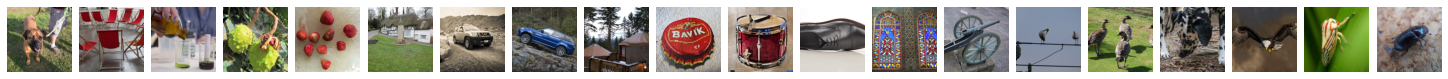

In [60]:
# grab the inception v3 model
model = models.resnet18(pretrained=True).eval()
dataset = 'imagenet'
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)
batch_size = 20
images, labels = ep.astensors(*samples(fmodel, dataset="imagenet", batchsize=batch_size))

clean_acc = accuracy(fmodel, images, labels)
predictions = fmodel(images).argmax(-1)
plot.images(images)
print("labels     : ", [label_to_name(l) for l in labels.numpy()])
print("predictions: ", [label_to_name(l) for l in predictions.numpy()])

print(f"clean accuracy:  {clean_acc * 100:.1f} %")
print("")

# Perform the Attack

In [ ]:
%matplotlib inline

attacks = [
        fa.BoundaryAttack(),
        fa.LinfAdditiveUniformNoiseAttack(),
    ]
epsilons = [
        0.0,
        0.0005,
        0.001,
        0.0015,
        0.002,
        0.003,
        0.005,
        0.01,
        0.02,
        0.03,
        0.1,
        0.3,
        0.5,
        1.0,
    ]
print("epsilons")
print(epsilons)
print("")

attack_success = np.zeros((len(attacks), len(epsilons), len(images)), dtype=np.bool)
for i, attack in enumerate(attacks):
    t1 = time.time()
    # The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.
    # The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.
    # The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.
    raw_adv, clipped_adv, is_adv = attack(fmodel, images, labels, epsilons=epsilons)
    t2 = time.time()
    success_ = is_adv.numpy()
    attack_success[i] = success_
    print(attack)
    print("  ", 1.0 - success_.mean(axis=-1).round(2))
    print("Time taken: ", (t2 - t1) / batch_size, "seconds")

    # plot the robust accuracy against epsilons for the particular attack
    robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
    plt.plot(epsilons, robust_accuracy.numpy())

    plot(clipped_adv[0])


epsilons
[0.0, 0.0005, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.1, 0.3, 0.5, 1.0]



# Analysis

In [ ]:
 # calculate and report the robust accuracy (the accuracy of the model when
    # it is attacked) using the best attack per sample
robust_accuracy = 1.0 - attack_success.max(axis=0).mean(axis=-1)
print("")
print("-" * 79)
print("")
print("worst case (best attack per-sample)")
print("  ", robust_accuracy.round(2))
print("")

print("robust accuracy for perturbations with")
for eps, acc in zip(epsilons, robust_accuracy):
    print(f"  Linf norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

# How to Run Targeted Attack

In [ ]:
%matplotlib inline

# print the correct labels
labels

# targeted classes (to be flipped to)
target_classes = (labels + 200) % 1000
target_classes
criterion = criteria.TargetedMisclassification(target_classes)
# untargeted
# criterion = criteria.Misclassification(labels)


# perform the attack with 100 steps
attack = fa.LinfAdditiveUniformNoiseAttack(steps=100)
advs, _, is_adv = attack(fmodel, images, criterion, epsilons=None)

# check if these are true adversaries, whether a flip has happened
is_adv

# check the linf distances
distances.linf(images, advs)

# attack success rate
attack_success_rate = is_adv.float32().mean(axis=-1)
attack_success_rate

# plot the attack success rate against epsilons
# plt.plot(epsilons, attack_success_rate.numpy())

# plot the original images
plot.images(images)

# plot the perturbed images
plot.images(advs)

# plot the difference
plot.images(advs - images, n=4, bounds=(-0.1, 0.1), scale=4.)


# Loading Your Own Model

In [ ]:
def create() -> PyTorchModel:
    model = nn.Sequential(
        nn.Conv2d(1, 32, 3),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout2d(0.25),
        nn.Flatten(),  
        nn.Linear(9216, 128),
        nn.ReLU(),
        nn.Dropout2d(0.5),
        nn.Linear(128, 10),
    )
    path = "your data path"
    model.load_state_dict(torch.load(path))
    model.eval()
    preprocessing = dict(mean=0.1307, std=0.3081)
    fmodel = PyTorchModel(model, bounds=(0, 1), preprocessing=preprocessing)
    return fmodel


fmodel = create()
images, labels = samples(fmodel, dataset="mnist", batchsize=20)
print(accuracy(fmodel, images, labels))